In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install Required Libraries
!pip install transformers scikit-learn pandas torch peft umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 6.2 MB/s eta 0:00:00


In [3]:
import pandas as pd
import torch
import numpy as np
from transformers import AutoTokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from peft import LoraConfig, get_peft_model
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sklearn.manifold import TSNE


# Load LLM

In [4]:
# Load ClinicalT5 model
model_name = "luqh/ClinicalT5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name, from_flax=True)

# GPU Check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/664 [00:00<?, ?B/s]

flax_model.msgpack:   0%|          | 0.00/892M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_flax_pytorch_utils.py:459: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  pt_model_dict[flax_key] = torch.from_numpy(flax_tensor)
All Flax model weights were used when initializing T5ForConditionalGeneration.

Some weights of T5ForConditionalGeneration were not initialized from the Flax model and are newly initialized: ['decoder.embed_tokens.weight', 'encoder.embed_tokens.weight', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Load File

In [5]:
# Load Pre-split Datasets
train_path = "/content/drive/MyDrive/P2/T1/Dataset/non_overlapped/LLM-no-train.csv"
val_path = "/content/drive/MyDrive/P2/T1/Dataset/non_overlapped/LLM-no-val.csv"
test_path = "/content/drive/MyDrive/P2/T1/Dataset/non_overlapped/LLM-no-test.csv"

train_data = pd.read_csv(train_path)
val_data = pd.read_csv(val_path)
test_data = pd.read_csv(test_path)

In [6]:
# Encode Disease Labels
label_encoder = LabelEncoder()
train_data['encoded_labels'] = label_encoder.fit_transform(train_data['disease_label'])
val_data['encoded_labels'] = label_encoder.transform(val_data['disease_label'])
test_data['encoded_labels'] = label_encoder.transform(test_data['disease_label'])

num_classes = len(label_encoder.classes_)

# LoRA (Low-Rank Adaptation)

In [7]:
from peft import LoraConfig, get_peft_model

# Configure LoRA for ClinicalT5
lora_config = LoraConfig(
    r=32,  # Low-rank adaptation rank
    lora_alpha=64,  # Scaling factor
    target_modules=[
        "encoder.block.0.layer.0.SelfAttention.q",
        "encoder.block.0.layer.0.SelfAttention.v",
        "decoder.block.0.layer.0.SelfAttention.q",
        "decoder.block.0.layer.0.SelfAttention.v",
        "decoder.block.0.layer.1.EncDecAttention.q",
        "decoder.block.0.layer.1.EncDecAttention.v"
    ],
    lora_dropout=0.2,  # Dropout rate for regularization
    task_type="SEQ_2_SEQ_LM"  # Corrected task type for sequence-to-sequence language modeling
)

# Apply LoRA to the ClinicalT5 model
model = get_peft_model(model, lora_config)
print("LoRA applied successfully to ClinicalT5!")


LoRA applied successfully to ClinicalT5!


# Tokenize Symptoms

In [8]:
# Tokenize the datasets
def tokenize_texts(texts):
    return tokenizer(texts.tolist(), padding=True, truncation=True, max_length=128, return_tensors="pt")

train_encodings = tokenize_texts(train_data['symptoms'])
val_encodings = tokenize_texts(val_data['symptoms'])
test_encodings = tokenize_texts(test_data['symptoms'])  # Fixed: Use test_data['symptoms']

# Tokenize the labels
def tokenize_labels(labels):
    return tokenizer(labels.tolist(), padding=True, truncation=True, max_length=128, return_tensors="pt")

train_labels = tokenize_labels(label_encoder.inverse_transform(train_data['encoded_labels']))
val_labels = tokenize_labels(label_encoder.inverse_transform(val_data['encoded_labels']))
test_labels = tokenize_labels(label_encoder.inverse_transform(test_data['encoded_labels']))  # Fixed: Use test_data['encoded_labels']

# Dataset class for fine-tuning
class SymptomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels_encodings):
        self.encodings = encodings
        self.labels_encodings = labels_encodings

    def __len__(self):
        return len(self.labels_encodings['input_ids'])

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['decoder_input_ids'] = self.labels_encodings['input_ids'][idx]
        item['decoder_attention_mask'] = self.labels_encodings['attention_mask'][idx]
        item['labels'] = self.labels_encodings['input_ids'][idx]  # labels are also decoder ids
        return item

# Create PyTorch Datasets
train_dataset = SymptomDataset(train_encodings, train_labels)
val_dataset = SymptomDataset(val_encodings, val_labels)
test_dataset = SymptomDataset(test_encodings, test_labels)  # Fixed: Create test dataset


# Fine-tuning ClinicalT5

In [9]:
# Fine-Tuning BioBERT
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    logging_strategy="steps",  # Enable logging after a fixed number of steps
    logging_steps=10,  # Log training loss every 10 steps
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=6,
    weight_decay= 0.001,
    logging_dir="./logs",
    save_strategy="epoch",
    save_total_limit=2
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [10]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,1.412900,0.895482
2,0.817800,0.355697
3,0.620500,0.155418
4,0.525000,0.085709
5,0.428700,0.064588
6,0.424100,0.058473


TrainOutput(global_step=14022, training_loss=1.0318323143146428, metrics={'train_runtime': 1476.8732, 'train_samples_per_second': 151.878, 'train_steps_per_second': 9.494, 'total_flos': 1.7633718003990528e+16, 'train_loss': 1.0318323143146428, 'epoch': 6.0})

# Generate ClinicalT5 Embedding for MLs

In [14]:
from torch.utils.data import DataLoader, Dataset

class TextDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]

def generate_t5_embeddings_batch(data, column, tokenizer, model, device, batch_size=16):
    dataset = TextDataset(data[column].tolist())
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    all_embeddings = []
    for batch in dataloader:
        inputs = tokenizer(list(batch), return_tensors="pt", padding=True, truncation=True, max_length=128)
        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)

        with torch.no_grad():
            encoder_outputs = model.encoder(input_ids=input_ids, attention_mask=attention_mask)
            embeddings = encoder_outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            all_embeddings.extend(embeddings)
    return all_embeddings

# Generate embeddings with batching
print("Generating embeddings for training data...")
train_embeddings = generate_t5_embeddings_batch(train_data, "symptoms", tokenizer, model, device, batch_size=16)
print("Generating embeddings for validation data...")
val_embeddings = generate_t5_embeddings_batch(val_data, "symptoms", tokenizer, model, device, batch_size=16)
print("Generating embeddings for testing data...")
test_embeddings = generate_t5_embeddings_batch(test_data, "symptoms", tokenizer, model, device, batch_size=16)


Generating embeddings for training data...
Generating embeddings for validation data...
Generating embeddings for testing data...


# UMAP (Uniform Manifold Approximation and Projection)



Reducing dimensions using UMAP...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


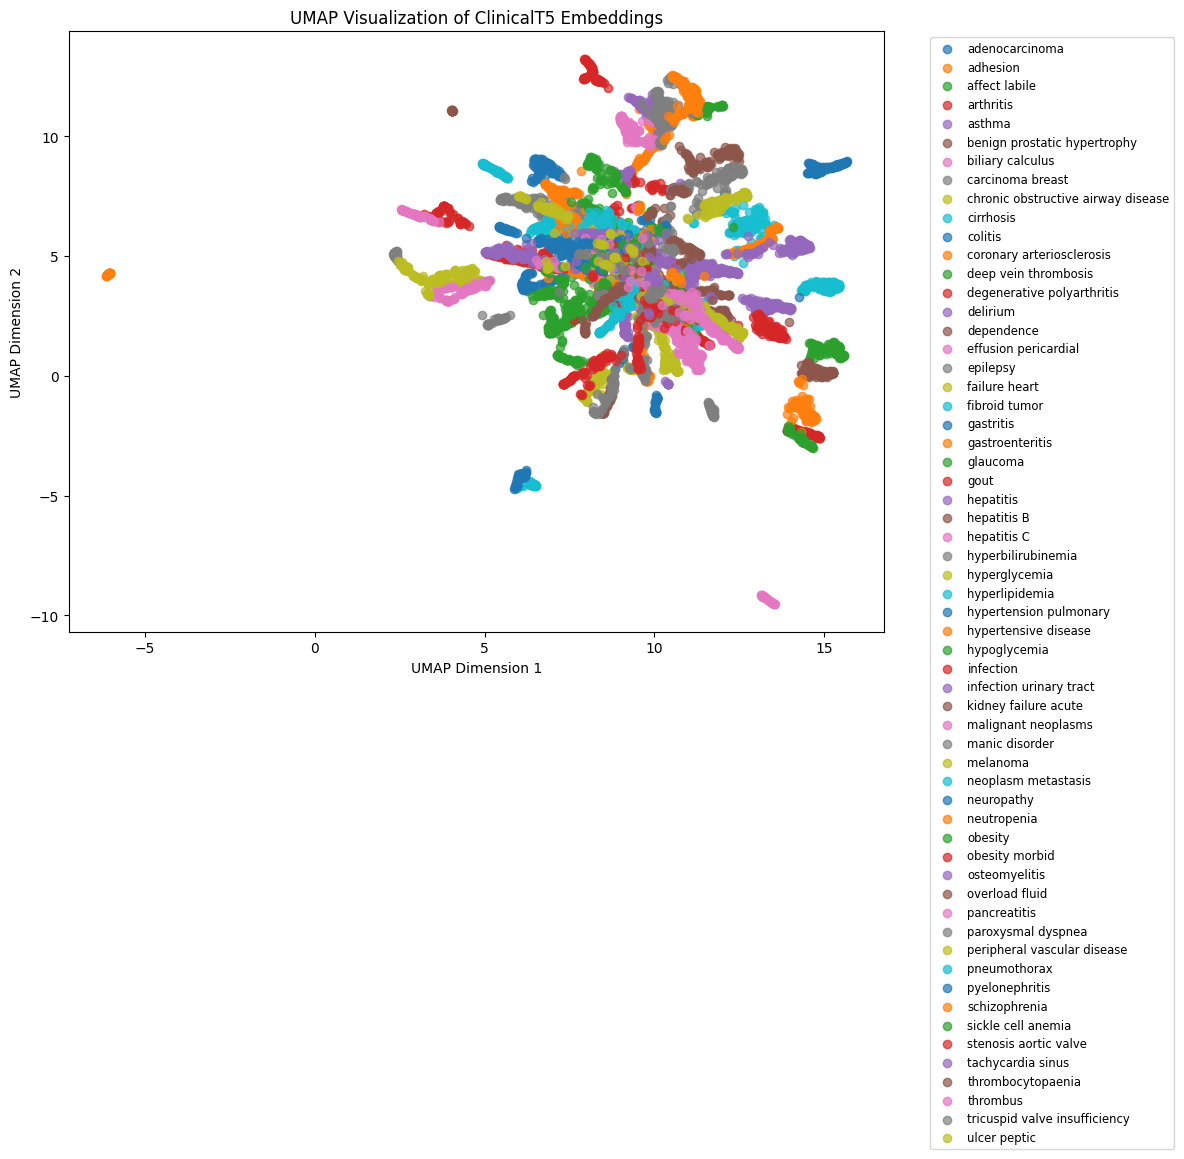

In [15]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
import numpy as np

# Generate test embeddings (ensure this is executed before using UMAP)
# test_embeddings should already be generated using your generate_embeddings function.

# Convert test labels to NumPy for easier handling
labels = test_labels.cpu().numpy()  # Ensure this is defined and matches the test dataset

# Reduce dimensions using UMAP
print("Reducing dimensions using UMAP...")
umap_model = umap.UMAP(n_components=2, random_state=42)
reduced_embeddings = umap_model.fit_transform(test_embeddings)

# Map numeric labels to disease names
disease_names = label_encoder.inverse_transform(labels)  # Map numeric labels to actual disease names

# Plot the 2D representation
plt.figure(figsize=(12, 10))
unique_labels = np.unique(disease_names)

for disease in unique_labels:
    indices = np.where(disease_names == disease)
    plt.scatter(
        reduced_embeddings[indices, 0], reduced_embeddings[indices, 1],
        label=disease, alpha=0.7
    )

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.title("UMAP Visualization of ClinicalT5 Embeddings")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.tight_layout()
plt.show()


# t-SNE ( t-Distributed Stochastic Neighbor Embedding)

Reducing dimensions using t-SNE...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


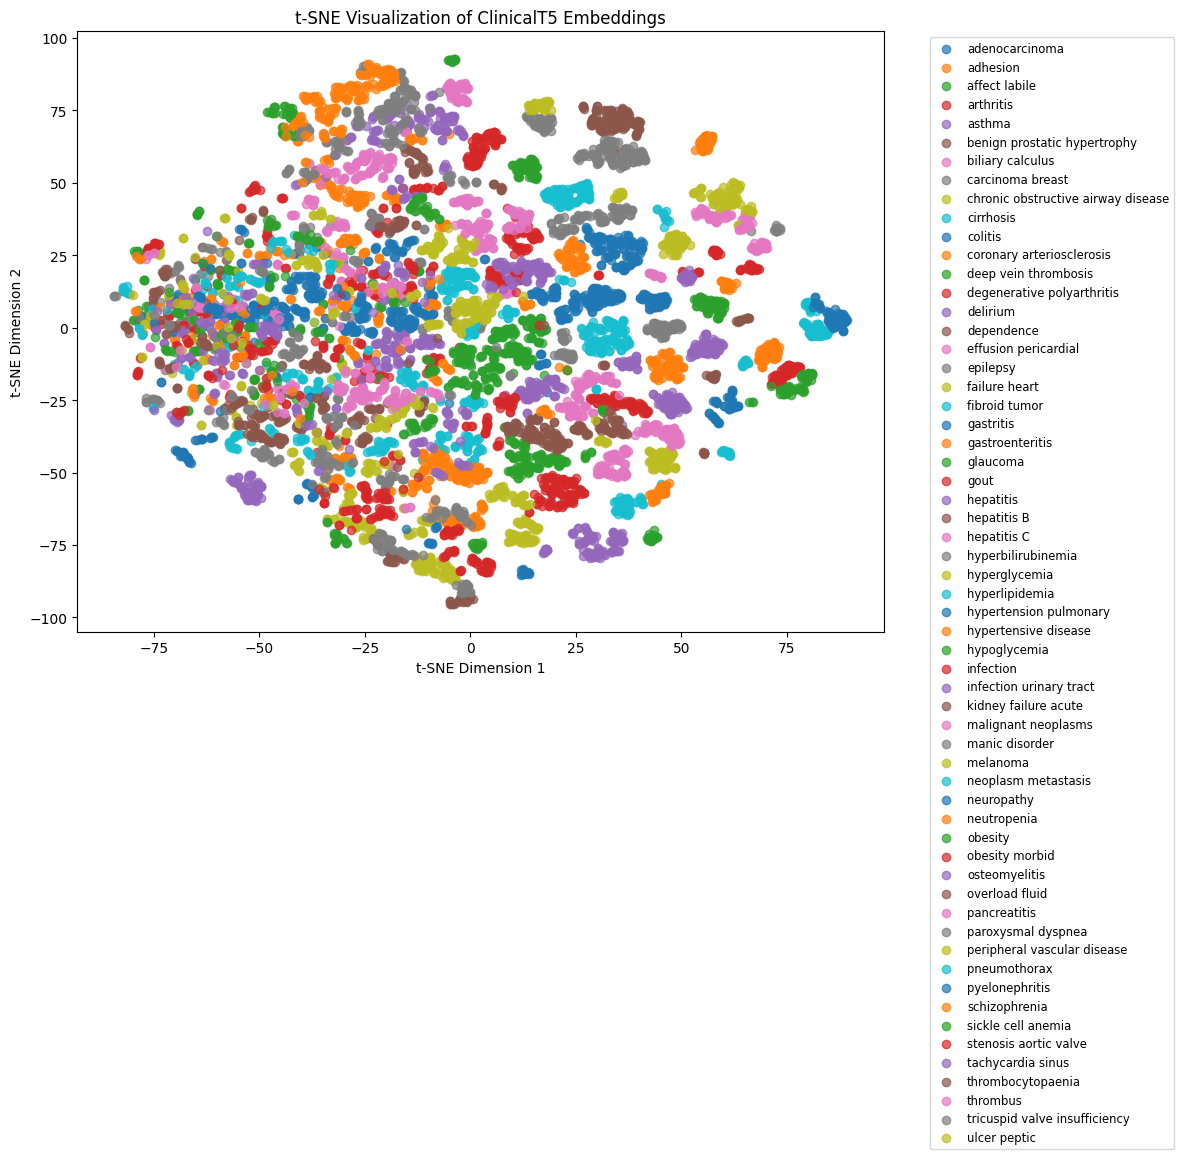

In [16]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Ensure test_labels is a NumPy array
if isinstance(test_labels, list):
    test_labels = np.array(test_labels)  # Convert list to NumPy array
elif hasattr(test_labels, "cpu"):
    test_labels = test_labels.cpu().numpy()  # Convert PyTorch tensor to NumPy array if applicable

# Convert test_embeddings to a NumPy array
test_embeddings = np.array(test_embeddings)

# Reduce dimensions using t-SNE
print("Reducing dimensions using t-SNE...")
tsne_model = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
reduced_embeddings_tsne = tsne_model.fit_transform(test_embeddings)

# Map numeric labels to disease names
disease_names = label_encoder.inverse_transform(test_labels)  # Map numeric labels to actual disease names

# Plot the 2D representation for t-SNE
plt.figure(figsize=(12, 10))
unique_labels = np.unique(disease_names)

for disease in unique_labels:
    indices = np.where(disease_names == disease)
    plt.scatter(
        reduced_embeddings_tsne[indices, 0], reduced_embeddings_tsne[indices, 1],
        label=disease, alpha=0.7
    )

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.title("t-SNE Visualization of ClinicalT5 Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.tight_layout()
plt.show()

# Naive Bayes

In [17]:
# Train Naive Bayes
nb_model = GaussianNB()
nb_model.fit(train_embeddings, train_data['encoded_labels'])

# Validate the Model
val_preds = nb_model.predict(val_embeddings)
# Use original encoded labels for validation report
val_report = classification_report(val_data['encoded_labels'], val_preds, target_names=label_encoder.classes_, output_dict=True)
print("Validation Report:")
print(pd.DataFrame(val_report))

# Test the Model
test_preds = nb_model.predict(test_embeddings)
# Use original encoded labels for test report
test_report = classification_report(test_data['encoded_labels'], test_preds, target_names=label_encoder.classes_, output_dict=True)
print("Test Report:")
print(pd.DataFrame(test_report))


Validation Report:
           adenocarcinoma    adhesion  affect labile   arthritis     asthma  \
precision        0.833333    0.986667       0.857143    0.743243   0.846154   
recall           0.597484    0.462500       0.320000    0.447154   0.309859   
f1-score         0.695971    0.629787       0.466019    0.558376   0.453608   
support        159.000000  160.000000      75.000000  123.000000  71.000000   

           benign prostatic hypertrophy  biliary calculus  carcinoma breast  \
precision                      0.838710          0.304348          0.573099   
recall                         0.346667          0.575342          0.604938   
f1-score                       0.490566          0.398104          0.588589   
support                       75.000000        146.000000        162.000000   

           chronic obstructive airway disease   cirrhosis  ...  \
precision                            0.659091    0.609890  ...   
recall                               0.487395    0.685185

In [18]:
# Save Classification Report to CSV
test_report_df = pd.DataFrame(test_report).transpose()
test_report_path = "/content/drive/MyDrive/P2/T1/Dataset/non_overlapped/LLM + ML/clinicalT5-nb-o-class.csv"
test_report_df.to_csv(test_report_path, index=True)
print(f"Classification report saved to {test_report_path}")

Classification report saved to /content/drive/MyDrive/P2/T1/Dataset/non_overlapped/LLM + ML/clinicalT5-nb-o-class.csv


# Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier
# Train Random Forest on Embeddings
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(train_embeddings, train_data['encoded_labels'])

# Validate the Model
val_preds = rf_model.predict(val_embeddings)
# Use original encoded labels for validation report
val_report = classification_report(val_data['encoded_labels'], val_preds, target_names=label_encoder.classes_, output_dict=True)
print("Validation Report:")
print(pd.DataFrame(val_report))

# Test the Model
test_preds = rf_model.predict(test_embeddings)
# Use original encoded labels for test report
test_report = classification_report(test_data['encoded_labels'], test_preds, target_names=label_encoder.classes_, output_dict=True)
print("Test Report:")
print(pd.DataFrame(test_report))

Validation Report:
           adenocarcinoma    adhesion  affect labile   arthritis     asthma  \
precision        0.992647    0.906475       1.000000    1.000000   1.000000   
recall           0.849057    0.787500       0.373333    0.552846   0.690141   
f1-score         0.915254    0.842809       0.543689    0.712042   0.816667   
support        159.000000  160.000000      75.000000  123.000000  71.000000   

           benign prostatic hypertrophy  biliary calculus  carcinoma breast  \
precision                      1.000000          0.692683          0.735160   
recall                         0.453333          0.972603          0.993827   
f1-score                       0.623853          0.809117          0.845144   
support                       75.000000        146.000000        162.000000   

           chronic obstructive airway disease   cirrhosis  ...  \
precision                            1.000000    0.744186  ...   
recall                               0.672269    0.987654

In [20]:
# Save Classification Report to CSV
test_report_df = pd.DataFrame(test_report).transpose()
test_report_path = "/content/drive/MyDrive/P2/T1/Dataset/non_overlapped/LLM + ML/clinicalT5-rf-o-class.csv"
test_report_df.to_csv(test_report_path, index=True)
print(f"Classification report saved to {test_report_path}")

Classification report saved to /content/drive/MyDrive/P2/T1/Dataset/non_overlapped/LLM + ML/clinicalT5-rf-o-class.csv


# Support Vector Classifier

In [21]:
# Train Support Vector Classifier (SVC) on Embeddings
from sklearn.svm import SVC

svc_model = SVC(kernel='linear', random_state=42)  # You can choose other kernels like 'rbf' or 'poly'
svc_model.fit(train_embeddings, train_data['encoded_labels'])

# Validate the Model
val_preds = svc_model.predict(val_embeddings)
# Use original encoded labels for validation report
val_report = classification_report(val_data['encoded_labels'], val_preds, target_names=label_encoder.classes_, output_dict=True)
print("Validation Report:")
print(pd.DataFrame(val_report))

# Test the Model
test_preds = svc_model.predict(test_embeddings)
# Use original encoded labels for test report
test_report = classification_report(test_data['encoded_labels'], test_preds, target_names=label_encoder.classes_, output_dict=True)
print("Test Report:")
print(pd.DataFrame(test_report))

Validation Report:
           adenocarcinoma  adhesion  affect labile   arthritis     asthma  \
precision        1.000000    0.9875       1.000000    1.000000   1.000000   
recall           0.974843    0.9875       0.866667    0.926829   0.985915   
f1-score         0.987261    0.9875       0.928571    0.962025   0.992908   
support        159.000000  160.0000      75.000000  123.000000  71.000000   

           benign prostatic hypertrophy  biliary calculus  carcinoma breast  \
precision                      0.985507          0.935484          0.987805   
recall                         0.906667          0.993151          1.000000   
f1-score                       0.944444          0.963455          0.993865   
support                       75.000000        146.000000        162.000000   

           chronic obstructive airway disease   cirrhosis  ...  \
precision                            1.000000    0.964072  ...   
recall                               0.924370    0.993827  ...   
f

In [22]:
# Save Classification Report to CSV
test_report_df = pd.DataFrame(test_report).transpose()
test_report_path = "/content/drive/MyDrive/P2/T1/Dataset/non_overlapped/LLM + ML/clinicalT5-svc-o-class.csv"
test_report_df.to_csv(test_report_path, index=True)
print(f"Classification report saved to {test_report_path}")

Classification report saved to /content/drive/MyDrive/P2/T1/Dataset/non_overlapped/LLM + ML/clinicalT5-svc-o-class.csv
